In [14]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset, random_split

import torch.optim as optim

import os
import json
from sklearn.preprocessing import LabelEncoder

import numpy as np
import math

import tool as tl

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


In [7]:
model_path = 'model/final_model_1000_red.pth'


input_dim, model_dim, num_heads, num_layers, num_classes, learning_rate = 70*3, 512, 8, 2, 501, 0.00001

In [8]:
checkpoint = torch.load(model_path)
model = tl.MultiEncoderTransformerModel(input_dim, model_dim, num_heads, num_layers, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()  # Set the model to evaluation mode (or model.train() if resuming training)

# GPU 사용 여부 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MultiEncoderTransformerModel(
  (face_input_fc): Linear(in_features=210, out_features=512, bias=True)
  (face_positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (face_transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pose_input_fc): Linear(in_features=210, out_features=512, bias=True)
  (

In [9]:
batch_size = 64

# 테스트 데이터셋과 데이터 로더
test_encoded_labels, encoder = tl.get_word_list(10, 10)
test_sequence_files = tl.get_sequence_files(10, 10)

test_dataset = tl.SignLanguageDataset(test_sequence_files, test_encoded_labels)  # 실제 테스트 데이터셋 경로와 라벨 사용
test_loader = tl.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=tl.collate_fn)

In [11]:
# 평가 지표 초기화
all_labels = []
all_predictions = []

def create_padding_mask(sequences, pad_token=0):
    return (sequences == pad_token)
        

with torch.no_grad():
    for (face_sequence, pose_sequence, left_hand_sequence, right_hand_sequence), labels, lengths, idx in test_loader:
        
        face_sequence, pose_sequence, left_hand_sequence, right_hand_sequence = face_sequence.to(device), pose_sequence.to(device), left_hand_sequence.to(device), right_hand_sequence.to(device)
        labels = labels.to(device)

        # 입력 텐서 변환: [batch_size, 3, seq_len, num_joints] -> [batch_size, seq_len, 3 * num_joints]
        batch_size, coord, seq_len, num_joints = face_sequence.size()
        face_sequence = face_sequence.permute(0, 2, 3, 1).contiguous()  # [batch_size, seq_len, num_joints, coord]
        face_sequence = face_sequence.view(batch_size, seq_len, -1)  # [batch_size, seq_len, num_joints * coord]
        
        batch_size, coord, seq_len, num_joints = pose_sequence.size()
        pose_sequence = pose_sequence.permute(0, 2, 3, 1).contiguous()  # [batch_size, seq_len, num_joints, coord]
        pose_sequence = pose_sequence.view(batch_size, seq_len, -1)  # [batch_size, seq_len, num_joints * coord]
        
        batch_size, coord, seq_len, num_joints = left_hand_sequence.size()
        left_hand_sequence = left_hand_sequence.permute(0, 2, 3, 1).contiguous()  # [batch_size, seq_len, num_joints, coord]
        left_hand_sequence = left_hand_sequence.view(batch_size, seq_len, -1)  # [batch_size, seq_len, num_joints * coord]
        
        batch_size, coord, seq_len, num_joints = right_hand_sequence.size()
        right_hand_sequence = right_hand_sequence.permute(0, 2, 3, 1).contiguous()  # [batch_size, seq_len, num_joints, coord]
        right_hand_sequence = right_hand_sequence.view(batch_size, seq_len, -1)  # [batch_size, seq_len, num_joints * coord]
        
        # 패딩 마스크 생성
        face_src_key_padding_mask = create_padding_mask(face_sequence[:,:,0])
        face_src_key_padding_mask = face_src_key_padding_mask.to(device)
        pose_src_key_padding_mask = create_padding_mask(pose_sequence[:,:,0])
        pose_src_key_padding_mask = pose_src_key_padding_mask.to(device)
        left_src_key_padding_mask = create_padding_mask(left_hand_sequence[:,:,0])
        left_src_key_padding_mask = left_src_key_padding_mask.to(device)
        right_src_key_padding_mask = create_padding_mask(right_hand_sequence[:,:,0])
        right_src_key_padding_mask = right_src_key_padding_mask.to(device)

        outputs = model(face_sequence, pose_sequence, left_hand_sequence, right_hand_sequence, face_src_key_padding_mask, pose_src_key_padding_mask, left_src_key_padding_mask, right_src_key_padding_mask)
        
        
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted_classes = torch.max(probabilities, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_classes.cpu().numpy())


/home/yohan-ban/anaconda3/envs/project/lib/python3.10/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


In [15]:
# 정확도 및 기타 성능 지표 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.6480
Precision: 0.5652
Recall: 0.6480
F1-Score: 0.5868


/home/yohan-ban/anaconda3/envs/project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


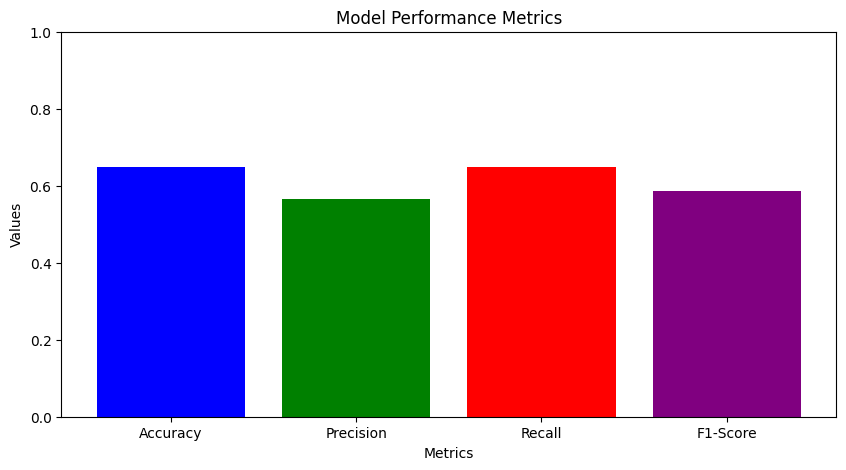

In [16]:
# 정확도 그래프 출력
def plot_accuracy(accuracy_values, title="Accuracy over Time"):
    plt.figure(figsize=(10, 5))
    plt.plot(accuracy_values, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()
plot_accuracy()

In [ ]:
import seaborn as sns

# 혼동 행렬 계산 및 시각화
conf_matrix = confusion_matrix(all_labels[:20], all_predictions[:20])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()